<h1> Preprocessing using Dataflow </h1>

This notebook illustrates:
<ol>
<li> Creating datasets for Machine Learning using Dataflow
</ol>
<p>
While Pandas is fine for experimenting, for operationalization of your workflow, it is better to do preprocessing in Apache Beam. This will also help if you need to preprocess data in flight, since Apache Beam also allows for streaming.

Apache Beam only works in Python 2 at the moment, so we're going to switch to the Python 2 kernel. In the above menu, click the dropdown arrow and select `python2`. 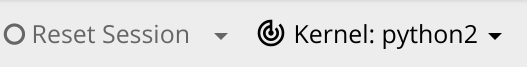

Then activate a Python 2 environment and install Apache Beam.

In [1]:
%%bash
source activate py2env
conda install -y pytz
pip uninstall -y google-cloud-dataflow
pip install --upgrade apache-beam[gcp]

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local/envs/py2env

  added / updated specs: 
    - pytz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    sqlite-3.25.3              |       h7b6447c_0         1.9 MB  defaults
    cryptography-2.4.1         |   py27h1ba5d50_0         606 KB  defaults
    certifi-2018.10.15         |           py27_0         139 KB  defaults
    sip-4.18                   |           py27_0         264 KB  defaults
    pyqt-4.11.4                |           py27_4         3.3 MB  defaults
    tk-8.6.8                   |       hbc83047_0         3.1 MB  defaults
    pytz-2018.7                |           py27_0         248 KB  defaults
    qt-4.8.7                   |                2        34.1 MB  defaults
    python-2.7.15              |       h9bab390_4        12.8 MB  defaults
    openssl-1.1.1a             | 



==> WARNING: A newer version of conda exists. <==
  current version: 4.5.10
  latest version: 4.5.11

Please update conda by running

    $ conda update -n base -c defaults conda


sqlite-3.25.3        | 1.9 MB    | ########## | 100% 
cryptography-2.4.1   | 606 KB    | ########## | 100% 
certifi-2018.10.15   | 139 KB    | ########## | 100% 
sip-4.18             | 264 KB    | ########## | 100% 
pyqt-4.11.4          | 3.3 MB    | ########## | 100% 
tk-8.6.8             | 3.1 MB    | ########## | 100% 
pytz-2018.7          | 248 KB    | ########## | 100% 
qt-4.8.7             | 34.1 MB   | ########## | 100% 
python-2.7.15        | 12.8 MB   | ########## | 100% 
openssl-1.1.1a       | 5.0 MB    | ########## | 100% 
pandas-gbq 0.3.0 has requirement google-cloud-bigquery>=0.28.0, but you'll have google-cloud-bigquery 0.25.0 which is incompatible.
google-cloud-monitoring 0.28.0 has requirement google-cloud-core<0.29dev,>=0.28.0, but you'll have google-cloud-core 0.25.0 which is incompatible

After doing a pip install, click **"Reset Session"** on the notebook so that the Python environment picks up the new packages.

In [3]:
import sys
print(sys.version_info)

sys.version_info(major=2, minor=7, micro=15, releaselevel='final', serial=0)


In [11]:
import os
output = os.popen("gcloud config get-value project").readlines()
project_name = output[0][:-1]

# change these to try this notebook out
PROJECT = project_name
BUCKET = project_name
BUCKET = BUCKET.replace("qwiklabs-gcp-", "inna-bckt-")
REGION = 'eu-west3'

print(PROJECT)
print(BUCKET)
print("gsutil mb -l {0} gs://{1}".format(REGION, BUCKET))

qwiklabs-gcp-3c0f7eb99276a8f1
inna-bckt-3c0f7eb99276a8f1
gsutil mb -l eu-west3 gs://inna-bckt-3c0f7eb99276a8f1


In [12]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [14]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

<h2> Create ML dataset using Dataflow </h2>
Let's use Cloud Dataflow to read in the BigQuery data, do some preprocessing, and write it out as CSV files.
In this case, I want to do some preprocessing, modifying data so that we can simulate what is known if no ultrasound has been performed. 
Note that after you launch this, the actual processing is happening on the cloud. Go to the GCP webconsole to the Dataflow section and monitor the running job. It took about 20 minutes for me.

Instead of using Beam/Dataflow, I had three other options:

* Use Cloud Dataprep to visually author a Dataflow pipeline. Cloud Dataprep also allows me to explore the data, so we could have avoided much of the handcoding of Python/Seaborn calls above as well!
* Read from BigQuery directly using TensorFlow.
* Use the BigQuery console (http://bigquery.cloud.google.com) to run a Query and save the result as a CSV file. For larger datasets, you may have to select the option to "allow large results" and save the result into a CSV file on Google Cloud Storage. 

<p>

However, in this case, I want to do some preprocessing, modifying data so that we can simulate what is known if no ultrasound has been performed. If I didn't need preprocessing, I could have used the web console. Also, I prefer to script it out rather than run queries on the user interface, so I am using Cloud Dataflow for the preprocessing.

<p>

If you wish to continue without doing this step, you can copy my preprocessed output:
<pre>
gsutil -m cp -r gs://cloud-training-demos/babyweight/preproc gs://your-bucket/
</pre>
But if you do this, you also have to use my TensorFlow model since yours might expect the fields in a different order

In [30]:
import apache_beam as beam
import datetime, os

"""
This function seems to be a generator, hence using the yield keyword instead of return. 
It seems to do the preprocessing of a single input row read from bigquery (probably).
Function will be called in Apache Beam's `.FlatMap` function.

rowdict = {u'hashmonth': 1525201076796226340, u'gestation_weeks': 40, u'is_male': False, u'weight_pounds': 8.75014717878, u'plurality': 1, u'mother_age': 34}


Explanation of `yield`:
To master yield, you must understand that when you call the function, the code you have written 
in the function body does not run. The function only returns the generator object; your code 
will be run each time the `for` uses the generator.
"""
def to_csv(rowdict):
  import hashlib
  import copy

  ## debug:
  #print(rowdict)
  
  # TODO #1:
  # Pull columns from BQ and create line(s) of CSV input
  CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks'.split(',')
    
  # Create synthetic data where we assume that no ultrasound has been performed
  # and so we don't know sex of the baby. Let's assume that we can tell the difference
  # between single and multiple, but that the errors rates in determining exact number
  # is difficult in the absence of an ultrasound.
  no_ultrasound = copy.deepcopy(rowdict)
  w_ultrasound = copy.deepcopy(rowdict)
  
  # print(w_ultrasound)
  # {'hashmonth': 1525201076796226340,
  #  'gestation_weeks': 40,
  #  'is_male': False,
  #  'weight_pounds': 8.75014717878,
  #  'plurality': 'Single(1)',
  #  'mother_age': 34}

  no_ultrasound['is_male'] = 'Unknown'
  if rowdict['plurality'] > 1:
    no_ultrasound['plurality'] = 'Multiple(2+)'
  else:
    no_ultrasound['plurality'] = 'Single(1)'

  # Change the plurality column to strings
  w_ultrasound['plurality'] = ['Single(1)', 
                               'Twins(2)', 
                               'Triplets(3)', 
                               'Quadruplets(4)', 
                               'Quintuplets(5)'][rowdict['plurality'] - 1]

  # Write out two rows for each input row, one with ultrasound and one without
  for result in [no_ultrasound, w_ultrasound]:
    data = ','.join([str(result[k]) if k in result else 'None' for k in CSV_COLUMNS])
    key = hashlib.sha224(data).hexdigest()  # hash the columns to form a key
    yield str('{},{}'.format(data, key))
    

# results from function above:
# data:  '8.75014717878,Unknown,34,Single(1),40'
# key:   'e96a75f2fe27ffdf5594cbc98f29ef808c32e9e1ad18741b28a6fbad'
# complete output:
# b'8.75014717878,Unknown,34,Single(1),40',e96a75f2fe27ffdf5594cbc98f29ef808c32e9e1ad18741b28a6fbad'


def preprocess(in_test_mode):
  import shutil, os, subprocess
  job_name = 'preprocess-babyweight-features' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')

  if in_test_mode:
      print('Launching local job ... hang on')
      OUTPUT_DIR = './preproc'
      shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
      os.makedirs(OUTPUT_DIR)
  else:
      print('Launching Dataflow job {} ... hang on'.format(job_name))
      OUTPUT_DIR = 'gs://{0}/babyweight/preproc/'.format(BUCKET)
      try:
        subprocess.check_call('gsutil -m rm -r {}'.format(OUTPUT_DIR).split())
      except:
        pass

  options = {
      'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
      'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
      'job_name': job_name,
      'project': PROJECT,
      'teardown_policy': 'TEARDOWN_ALWAYS',
      'no_save_main_session': True
  }
  opts = beam.pipeline.PipelineOptions(flags = [], **options)
  if in_test_mode:
      RUNNER = 'DirectRunner'   ## for local execution
  else:
      RUNNER = 'DataflowRunner' ## for execution in GCP
  p = beam.Pipeline(RUNNER, options = opts)
    
  query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
AND weight_pounds > 0
AND mother_age > 0
AND plurality > 0
AND gestation_weeks > 0
AND month > 0
    """

  if in_test_mode:
    query = query + ' LIMIT 100' 

  for step in ['train', 'eval']:
    if step == 'train':
      selquery = 'SELECT * FROM ({}) WHERE MOD(ABS(hashmonth),4) < 3'.format(query)
    else:
      selquery = 'SELECT * FROM ({}) WHERE MOD(ABS(hashmonth),4) = 3'.format(query)

    (p 
     ## TODO Task #2: Modify the Apache Beam pipeline such that the first part of the pipe reads the data from BigQuery
     | '{}_read'.format(step) >> beam.io.Read(beam.io.BigQuerySource(query = selquery, use_standard_sql = True)) 
     | '{}_csv'.format(step) >> beam.FlatMap(to_csv)
     | '{}_out'.format(step) >> beam.io.Write(beam.io.WriteToText(os.path.join(OUTPUT_DIR, '{}.csv'.format(step))))
    )

  job = p.run()
  if in_test_mode:
    job.wait_until_finish()
    print("Done!")
 
# TODO Task #3: Once you have verified that the files produced locally are correct, change in_test_mode to False
#               to execute this in Cloud Dataflow
preprocess(in_test_mode = False)

Launching Dataflow job preprocess-babyweight-features-181126-091025 ... hang on


/usr/local/envs/py2env/lib/python2.7/site-packages/apache_beam/runners/dataflow/dataflow_runner.py:795: DeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  standard_options = transform_node.inputs[0].pipeline.options.view_as(


### Check local output (from testing) and function

In [20]:
## check local output:
import shutil, os, subprocess
print(os.popen("pwd").read())
print(os.popen("ls ./preproc").read())


/content/datalab/gcp-ml-02-advanced-ml-with-tf-on-gcp/01-end-to-end-ml-with-tf-on-gcp/labs

eval.csv-00000-of-00001
train.csv-00000-of-00001



In [29]:
%%bash
head ./preproc/*.csv-00000-of-*


==> ./preproc/eval.csv-00000-of-00001 <==
8.56275425608,Unknown,18,Single(1),39,d851e7657ddcad3c997da8851d239f4d20d3c359af3e27677a24bd34
8.56275425608,False,18,Single(1),39,5041a58b56c815c577bd758758883708aa251ebcce3669d864a9b49d
5.65926626554,Unknown,19,Single(1),37,12834d955f536500e0c9f596da6f69b7fb5f0bd0376ff212c6fe8cbc
5.65926626554,False,19,Single(1),37,1c9ee74cc62ce20e28c3b7538862285957a72e3b3abb00e0442412ba
6.75055446244,Unknown,20,Single(1),39,49282c04a32e74625b5572a31a73c3242a7b8850dcff3b307cccca97
6.75055446244,False,20,Single(1),39,7461d31305751a40a49f2047e62c75ddcb2b6f2a2ae8fd599f2269f3
7.25100379718,Unknown,24,Single(1),38,dfc46df971576572d4a9e0e15da71370840857dd86d23544cffd49e2
7.25100379718,False,24,Single(1),38,acbb1a1816aebc9a9616ffe91dd8dd07b6bef5ebe5930a15c8a2e32a
7.0658154971,Unknown,25,Single(1),41,19c5ce8fd961303ce03d83b8fbf9acdbce395140bfc39f4e830efe44
7.0658154971,False,25,Single(1),41,c49ad70a348a7de3bb76f02a414a3790b6489e00925260af970ca285

==> ./preproc/train

Understanding `rowdict` in the `to_csv()` function above:
```python
def to_csv(rowdict):
  ## debug:
  print(rowdict)
```

produces this output:

```
{u'hashmonth': 1525201076796226340, u'gestation_weeks': 40, u'is_male': False, u'weight_pounds': 8.75014717878, u'plurality': 1, u'mother_age': 34}
{u'hashmonth': 411066950820961322, u'gestation_weeks': 38, u'is_male': False, u'weight_pounds': 9.06320359082, u'plurality': 1, u'mother_age': 27}
{u'hashmonth': 5742197815970064689, u'gestation_weeks': 38, u'is_male': False, u'weight_pounds': 6.686620406459999, u'plurality': 1, u'mother_age': 22}
```

In [25]:
query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
AND weight_pounds > 0
AND mother_age > 0
AND plurality > 0
AND gestation_weeks > 0
AND month > 0
    """
tmp = beam.io.BigQuerySource(query = query, use_standard_sql = True)
print(tmp)
type(tmp)

<BigQuerySource flatten_results=True, use_legacy_sql=False, query='\nSELECT\n  weight_pounds,\n  is_male,\n  mother_age,\n  plurality,\n  gestation_weeks,\n  ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth\nFROM\n  publicdata.samples.natality\nWHERE year > 2000\nAND weight_pounds > 0\nAND mother_age > 0\nAND plurality > 0\nAND gestation_weeks > 0\nAND month > 0\n    ', validate=False>


apache_beam.io.gcp.bigquery.BigQuerySource

### Check output from non-testing run

In [31]:
%bash
gsutil ls gs://${BUCKET}/babyweight/preproc/*-00000*

gs://inna-bckt-3c0f7eb99276a8f1/babyweight/preproc/eval.csv-00000-of-00012
gs://inna-bckt-3c0f7eb99276a8f1/babyweight/preproc/train.csv-00000-of-00041


In [42]:
%bash
gsutil cat -r -512 gs://${BUCKET}/babyweight/preproc/train.csv-00000-of-*

b8e42011deba5c8802bb7b613f71df03b6b345838ca1
6.4374980504,False,38,Single(1),42,f33012f3dd6aaf84f74454f62c96154a11159e329c13b685f802c09d
8.66637151922,Unknown,38,Single(1),41,e23a9aeb8dc470571658350f0347da2333cadfd5d23b383b363f1130
8.66637151922,True,38,Single(1),41,9d1e47220b1ba38164c5ff8aba64a4f0ab87282f45854c69ccf49458
6.59402625642,Unknown,38,Single(1),37,936b2c198555d5926a8fd873fc4adadb97dd334f85c4811466d9553d
6.59402625642,False,38,Single(1),37,9443157a561746d18595459505207cb1c02afce58f4b2277772ebbc7


In [43]:
%bash
gsutil cat -r -512 gs://${BUCKET}/babyweight/preproc/eval.csv-00000-of-*

0529a088625ff3216762dcf90422739c6f29bcfd3419
8.9617909503,False,29,Single(1),40,0ce2bfd9d2db4febd55e7c63faeb8a7c7e637bd17b2067256b5c064d
7.23777606146,Unknown,29,Single(1),45,25b792b6faea0adf13904ea1abf18eb7dd6533e3eed63190377240f0
7.23777606146,True,29,Single(1),45,a067f1d9bf4ba55b90f70ad36f53f360d0d546b79933170539c6776c
8.24969784404,Unknown,29,Single(1),39,01287455ca075fa88b45b9e0b592886acd0f360344fda3ed3a4f7922
8.24969784404,False,29,Single(1),39,3627f0c518d5ae4980379f1ef09f8987c465eb8dbcfd27e41b08d032


Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License